In [1]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bandarunagasaidhanya","key":"dd10939f45ecb4e5378165e254b12e2a"}'}

In [2]:
import os
import shutil

# Create .kaggle folder if not exists
os.makedirs("/root/.kaggle", exist_ok=True)

# Move kaggle.json to the correct directory
shutil.move("kaggle.json", "/root/.kaggle/kaggle.json")

# Set proper permissions
os.chmod("/root/.kaggle/kaggle.json", 600)

In [3]:
#!/bin/bash
!kaggle datasets download dmitrybabko/speech-emotion-recognition-en

Dataset URL: https://www.kaggle.com/datasets/dmitrybabko/speech-emotion-recognition-en
License(s): copyright-authors


In [4]:
import zipfile

zip_path = "/content/speech-emotion-recognition-en.zip"  # Full path to your ZIP file
extract_path = "/content/"  # Destination folder

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Unzipping completed!")

Unzipping completed!


In [5]:
import pandas as pd
import numpy as np
import os
import sys
import librosa
import librosa.display
import tensorflow as tf

# Fix imports for Keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Embedding, LSTM, BatchNormalization, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD

# Other necessary imports
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import IPython.display as ipd
from IPython.display import Audio

# Ignore warnings
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

print("Done")


Done


In [6]:
!apt-get update
!apt-get install -y libsndfile1

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:6 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,241 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,793 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Package

# Importing Data

In [7]:
#preparing data set

ravdess = "/content/Ravdess/audio_speech_actors_01-24/"
ravdess_directory_list = os.listdir(ravdess)
print(ravdess_directory_list)

['Actor_03', 'Actor_24', 'Actor_22', 'Actor_13', 'Actor_12', 'Actor_06', 'Actor_23', 'Actor_16', 'Actor_08', 'Actor_19', 'Actor_10', 'Actor_04', 'Actor_20', 'Actor_07', 'Actor_15', 'Actor_14', 'Actor_17', 'Actor_01', 'Actor_05', 'Actor_02', 'Actor_18', 'Actor_11', 'Actor_09', 'Actor_21']


In [8]:
Crema = "/content/Crema/"
Tess = "/content/Tess/"
Savee = "/content/Savee/"

# preprocessing

**Ravdees**

In [9]:
file_emotion = []
file_path = []
for i in ravdess_directory_list:
    # as their are 24 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(ravdess + i)
    for f in actor:
        part = f.split('.')[0].split('-')
    # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(ravdess + i + '/' + f)


In [10]:
print(actor[0])
print(part[0])
print(file_path[0])
print(int(part[2]))
print(f)

03-01-04-02-02-01-21.wav
03
/content/Ravdess/audio_speech_actors_01-24/Actor_03/03-01-05-02-02-01-03.wav
4
03-01-04-02-01-02-21.wav


In [11]:
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
ravdess_df = pd.concat([emotion_df, path_df], axis=1)
# changing integers to actual emotions.
ravdess_df.Emotions.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust',
                             8:'surprise'},
                            inplace=True)
print(ravdess_df.head())
print("______________________________________________")
print(ravdess_df.tail())
print("_______________________________________________")
print(ravdess_df.Emotions.value_counts())



  Emotions                                               Path
0    angry  /content/Ravdess/audio_speech_actors_01-24/Act...
1      sad  /content/Ravdess/audio_speech_actors_01-24/Act...
2      sad  /content/Ravdess/audio_speech_actors_01-24/Act...
3    angry  /content/Ravdess/audio_speech_actors_01-24/Act...
4      sad  /content/Ravdess/audio_speech_actors_01-24/Act...
______________________________________________
      Emotions                                               Path
1435     angry  /content/Ravdess/audio_speech_actors_01-24/Act...
1436   disgust  /content/Ravdess/audio_speech_actors_01-24/Act...
1437   neutral  /content/Ravdess/audio_speech_actors_01-24/Act...
1438  surprise  /content/Ravdess/audio_speech_actors_01-24/Act...
1439       sad  /content/Ravdess/audio_speech_actors_01-24/Act...
_______________________________________________
Emotions
neutral     288
angry       192
sad         192
happy       192
disgust     192
surprise    192
fear        192
Name: count, dty

<ipython-input-11-2e26f59c975e>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ravdess_df.Emotions.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust',


**Crema DataFrame**

In [12]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()
print(Crema_df.Emotions.value_counts())


Emotions
angry      1271
fear       1271
disgust    1271
happy      1271
sad        1271
neutral    1087
Name: count, dtype: int64


**TESS dataset**

In [13]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()
print(Tess_df.Emotions.value_counts())


Emotions
happy       400
angry       400
fear        400
neutral     400
disgust     400
surprise    400
sad         400
Name: count, dtype: int64


**SAVEE Dataset**

In [14]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()
print(Savee_df.Emotions.value_counts())


Emotions
neutral     120
angry        60
surprise     60
happy        60
sad          60
fear         60
disgust      60
Name: count, dtype: int64


**Integration**

In [15]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Emotions,Path
0,angry,/content/Ravdess/audio_speech_actors_01-24/Act...
1,sad,/content/Ravdess/audio_speech_actors_01-24/Act...
2,sad,/content/Ravdess/audio_speech_actors_01-24/Act...
3,angry,/content/Ravdess/audio_speech_actors_01-24/Act...
4,sad,/content/Ravdess/audio_speech_actors_01-24/Act...


In [16]:
print(data_path.Emotions.value_counts())


Emotions
angry       1923
sad         1923
happy       1923
fear        1923
disgust     1923
neutral     1895
surprise     652
Name: count, dtype: int64


>*                           Data Visualisation and Exploration

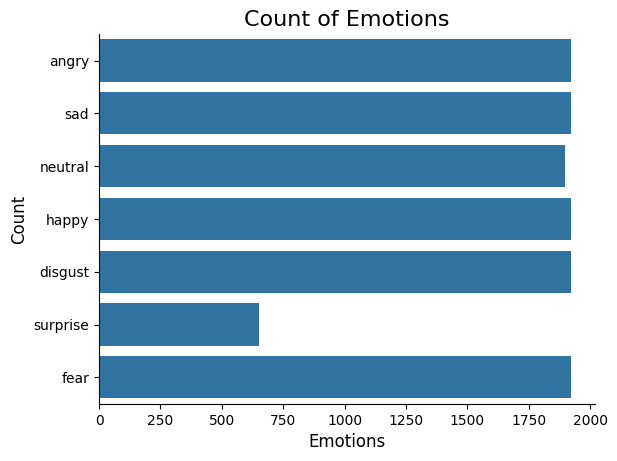

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [18]:
data,sr = librosa.load(file_path[0])
sr

22050

In [19]:
ipd.Audio(data,rate=sr)

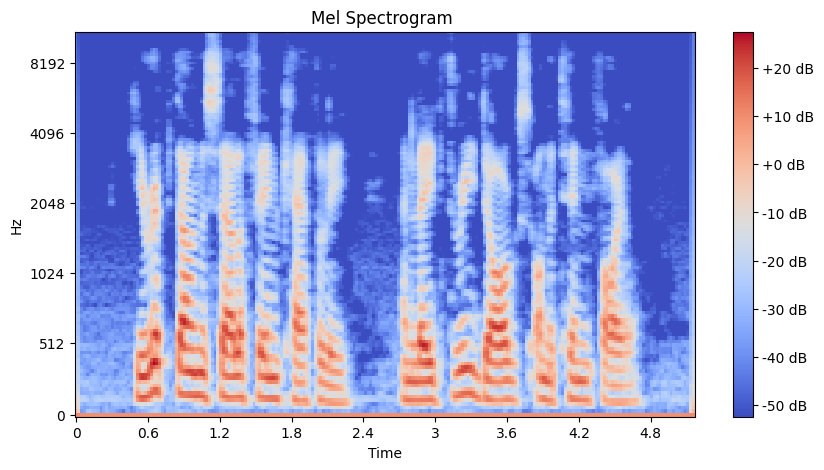

In [20]:
# CREATE LOG MEL SPECTROGRAM
plt.figure(figsize=(10, 5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000)
log_spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(log_spectrogram, y_axis='mel', sr=sr, x_axis='time');
plt.title('Mel Spectrogram ')
plt.colorbar(format='%+2.0f dB')

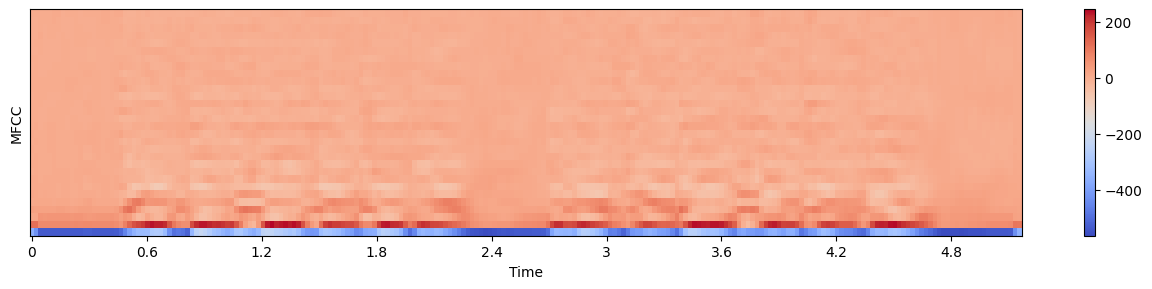

In [21]:
mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=30)


# MFCC
plt.figure(figsize=(16, 10))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(data,rate=sr)

# Data augmentation

In [22]:
# NOISE
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

# STRETCH
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(y=data, sr=rate)
# SHIFT
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)
# PITCH
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)



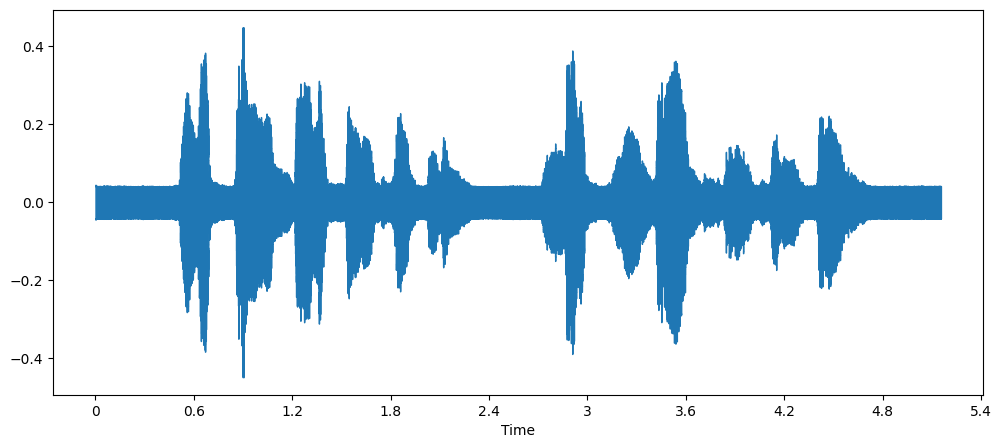

In [23]:
# NORMAL AUDIO


import librosa.display
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=data, sr=sr)
ipd.Audio(data,rate=sr)

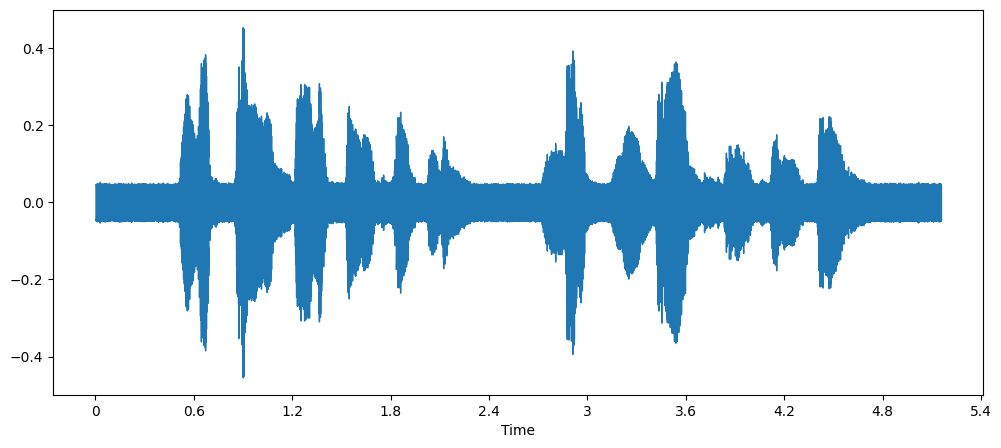

In [24]:
# AUDIO WITH NOISE
x = noise(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

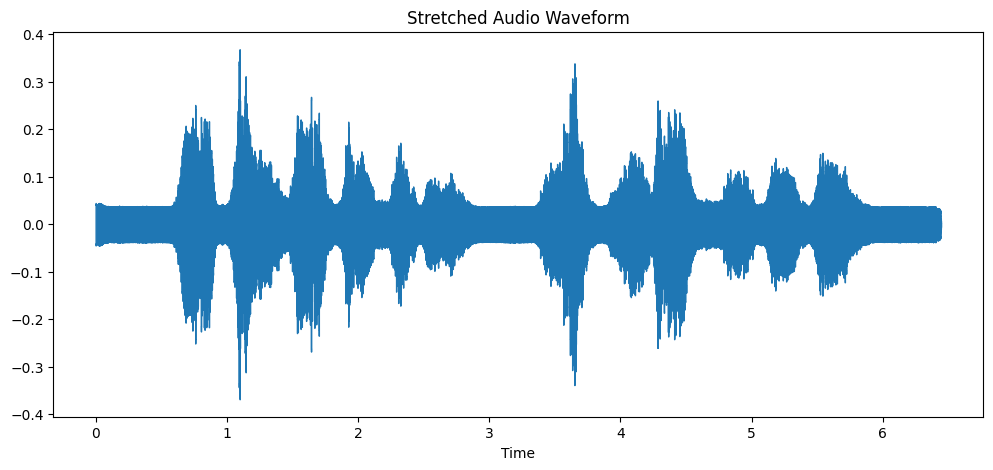

In [25]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd

# Corrected STRETCH function
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(y=data, rate=rate)  # Explicitly name 'rate'

# Apply stretch (Ensure 'data' and 'sr' are already defined)
x = stretch(data, rate=0.8)

# Plot stretched waveform
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sr)
plt.title("Stretched Audio Waveform")
plt.show()

# Play the stretched audio
ipd.Audio(x, rate=sr)


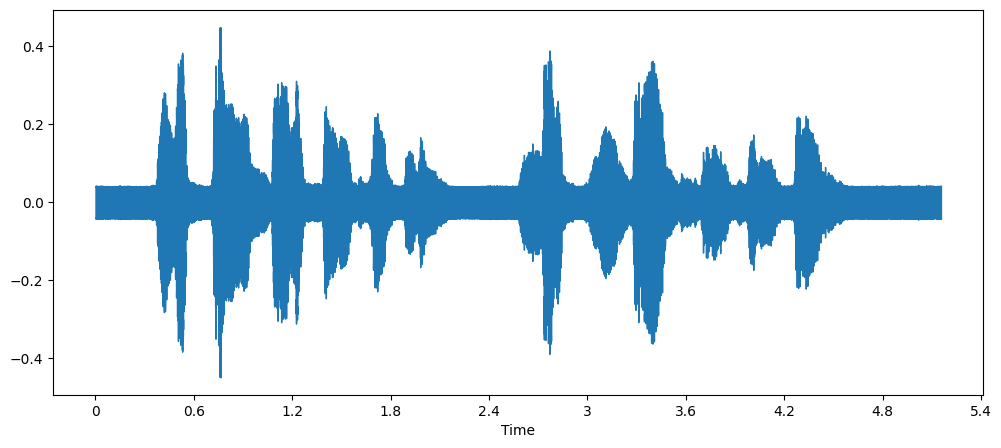

In [26]:
# SHIFTED AUDIO
x = shift(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

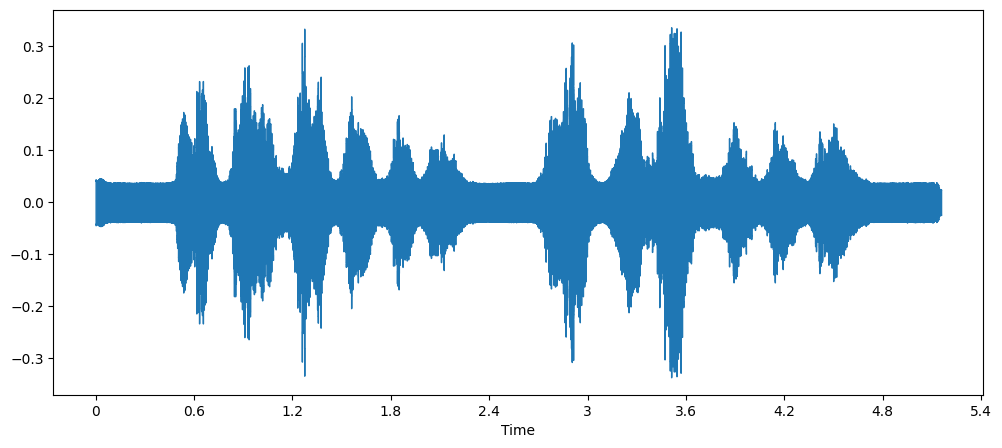

In [27]:
# AUDIO WITH PITCH
x = pitch(data, sr)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

# Feature extraction

In [28]:
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)
def rmse(data,frame_length=2048,hop_length=512):
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)
def mfcc(data,sr,frame_length=2048,hop_length=512,flatten:bool=True):
    mfcc = librosa.feature.mfcc(y=data, sr=sr)
    return np.squeeze(mfcc.T)if not flatten else np.ravel(mfcc.T)

def extract_features(data,sr=22050,frame_length=2048,hop_length=512):
    result=np.array([])

    result=np.hstack((result,
                      zcr(data,frame_length,hop_length),
                      rmse(data,frame_length,hop_length),
                      mfcc(data,sr,frame_length,hop_length)
                     ))
    return result

def get_features(path,duration=2.5, offset=0.6):
    data,sr=librosa.load(path,duration=duration,offset=offset)
    aud=extract_features(data)
    audio=np.array(aud)

    noised_audio=noise(data)
    aud2=extract_features(noised_audio)
    audio=np.vstack((audio,aud2))

    pitched_audio=pitch(data,sr)
    aud3=extract_features(pitched_audio)
    audio=np.vstack((audio,aud3))

    pitched_audio1=pitch(data,sr)
    pitched_noised_audio=noise(pitched_audio1)
    aud4=extract_features(pitched_noised_audio)
    audio=np.vstack((audio,aud4))

    return audio


In [29]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  2


# Noraml way to get features

In [30]:
import timeit
from tqdm import tqdm
start = timeit.default_timer()
X,Y=[],[]
for path,emotion,index in tqdm (zip(data_path.Path,data_path.Emotions,range(data_path.Path.shape[0]))):
    features=get_features(path)
    if index%500==0:
        print(f'{index} audio has been processed')
    for i in features:
        X.append(i)
        Y.append(emotion)
print('Done')
stop = timeit.default_timer()

print('Time: ', stop - start)

1it [00:00,  9.67it/s]

0 audio has been processed


502it [01:04,  9.06it/s]

500 audio has been processed


1002it [02:07,  9.00it/s]

1000 audio has been processed


1501it [03:09,  4.80it/s]

1500 audio has been processed


2003it [04:03, 10.94it/s]

2000 audio has been processed


2502it [04:55,  9.25it/s]

2500 audio has been processed


3002it [05:46,  4.72it/s]

3000 audio has been processed


3501it [06:36, 11.19it/s]

3500 audio has been processed


4002it [07:31,  5.51it/s]

4000 audio has been processed


4502it [08:21, 11.68it/s]

4500 audio has been processed


5001it [09:13, 11.14it/s]

5000 audio has been processed


5503it [10:05, 10.98it/s]

5500 audio has been processed


6003it [10:56, 10.87it/s]

6000 audio has been processed


6502it [11:50, 11.41it/s]

6500 audio has been processed


7002it [12:41, 10.93it/s]

7000 audio has been processed


7502it [13:33, 11.40it/s]

7500 audio has been processed


8002it [14:26, 10.80it/s]

8000 audio has been processed


8503it [15:20, 11.96it/s]

8500 audio has been processed


9003it [16:10, 13.78it/s]

9000 audio has been processed


9502it [16:53,  6.53it/s]

9500 audio has been processed


10002it [17:36, 11.37it/s]

10000 audio has been processed


10502it [18:14,  9.26it/s]

10500 audio has been processed


11001it [18:59, 10.95it/s]

11000 audio has been processed


11503it [19:49, 11.03it/s]

11500 audio has been processed


12002it [20:47,  8.75it/s]

12000 audio has been processed


12162it [21:07,  9.59it/s]

Done
Time:  1267.8659043950001


In [31]:
"""from joblib import Parallel, delayed
import timeit
start = timeit.default_timer()
# Define a function to get features for a single audio file
def process_feature(path, emotion):
    features = get_features(path)
    X = []
    Y = []
    for ele in features:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)
    return X, Y

paths = data_path.Path
emotions = data_path.Emotions

# Run the loop in parallel
results = Parallel(n_jobs=-1)(delayed(process_feature)(path, emotion) for (path, emotion) in zip(paths, emotions))

# Collect the results
X = []
Y = []
for result in results:
    x, y = result
    X.extend(x)
    Y.extend(y)


stop = timeit.default_timer()

print('Time: ', stop - start)    """

"from joblib import Parallel, delayed\nimport timeit\nstart = timeit.default_timer()\n# Define a function to get features for a single audio file\ndef process_feature(path, emotion):\n    features = get_features(path)\n    X = []\n    Y = []\n    for ele in features:\n        X.append(ele)\n        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.\n        Y.append(emotion)\n    return X, Y\n\npaths = data_path.Path\nemotions = data_path.Emotions\n\n# Run the loop in parallel\nresults = Parallel(n_jobs=-1)(delayed(process_feature)(path, emotion) for (path, emotion) in zip(paths, emotions))\n\n# Collect the results\nX = []\nY = []\nfor result in results:\n    x, y = result\n    X.extend(x)\n    Y.extend(y)\n\n\nstop = timeit.default_timer()\n\nprint('Time: ', stop - start)    "

In [32]:
len(X), len(Y), data_path.Path.shape


(48648, 48648, (12162,))

# Saving features

In [33]:
Emotions = pd.DataFrame(X)
Emotions['Emotions'] = Y
Emotions.to_csv('emotion.csv', index=False)
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
0,0.004395,0.004395,0.019043,0.070801,0.144531,0.153320,0.149414,0.117676,0.060059,0.063965,...,-8.509414,-15.959266,5.281013,-19.411232,11.092215,-17.532862,-4.795234,-5.260214,-4.159659,angry
1,0.249512,0.376465,0.499023,0.507324,0.508301,0.498047,0.494629,0.483398,0.475098,0.480957,...,-7.621308,-8.688517,3.507465,-8.952652,7.745049,-9.623394,-6.504068,-0.419547,-2.539883,angry
2,0.005371,0.005371,0.015625,0.050293,0.080078,0.081055,0.070801,0.036133,0.012695,0.012207,...,-9.025690,-12.267727,1.809870,-11.485384,15.150399,-18.823444,10.382528,-9.619539,0.672078,angry
3,0.250000,0.367676,0.491699,0.482422,0.491211,0.487305,0.479492,0.488770,0.486328,0.508301,...,-7.465772,-9.942878,-2.476458,-3.866464,8.122326,-10.617576,3.836697,-3.398441,-3.387618,angry
4,0.268555,0.414062,0.414062,0.338379,0.408691,0.449219,0.511719,0.467773,0.248047,0.062012,...,5.022761,5.025693,5.616106,5.968383,4.002924,3.817792,3.072495,1.242950,2.126480,sad


In [34]:
Emotions = pd.read_csv('./emotion.csv')
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
0,0.004395,0.004395,0.019043,0.070801,0.144531,0.153320,0.149414,0.117676,0.060059,0.063965,...,-8.509414,-15.959266,5.281013,-19.411232,11.092215,-17.532862,-4.795234,-5.260214,-4.159659,angry
1,0.249512,0.376465,0.499023,0.507324,0.508301,0.498047,0.494629,0.483398,0.475098,0.480957,...,-7.621308,-8.688517,3.507465,-8.952652,7.745049,-9.623394,-6.504068,-0.419547,-2.539883,angry
2,0.005371,0.005371,0.015625,0.050293,0.080078,0.081055,0.070801,0.036133,0.012695,0.012207,...,-9.025690,-12.267727,1.809870,-11.485384,15.150399,-18.823444,10.382528,-9.619539,0.672078,angry
3,0.250000,0.367676,0.491699,0.482422,0.491211,0.487305,0.479492,0.488770,0.486328,0.508301,...,-7.465772,-9.942878,-2.476458,-3.866464,8.122326,-10.617576,3.836697,-3.398441,-3.387618,angry
4,0.268555,0.414062,0.414062,0.338379,0.408691,0.449219,0.511719,0.467773,0.248047,0.062012,...,5.022761,5.025693,5.616106,5.968383,4.002924,3.817792,3.072495,1.242950,2.126480,sad


In [35]:
print(Emotions.isna().any())


0           False
1           False
2           False
3           False
4           False
            ...  
2372         True
2373         True
2374         True
2375         True
Emotions    False
Length: 2377, dtype: bool


In [36]:
Emotions=Emotions.fillna(0)
print(Emotions.isna().any())
Emotions.shape

0           False
1           False
2           False
3           False
4           False
            ...  
2372        False
2373        False
2374        False
2375        False
Emotions    False
Length: 2377, dtype: bool


(48648, 2377)

In [37]:
np.sum(Emotions.isna())

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


,0
0,0
1,0
2,0
3,0
4,0
...,...
2372,0
2373,0
2374,0
2375,0


# Data preparation

In [38]:
#taking all rows and all cols without last col for X which include features
#taking last col for Y, which include the emotions


X = Emotions.iloc[: ,:-1].values
Y = Emotions['Emotions'].values

In [39]:
# As this is a multiclass classification problem onehotencoding our Y
from sklearn.preprocessing import StandardScaler, OneHotEncoder
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()


In [40]:
print(Y.shape)
X.shape

(48648, 7)


(48648, 2376)

In [41]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42,test_size=0.2, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((38918, 2376), (38918, 7), (9730, 2376), (9730, 7))

In [42]:
#reshape for lstm
X_train = x_train.reshape(x_train.shape[0] , x_train.shape[1] , 1)
X_test = x_test.reshape(x_test.shape[0] , x_test.shape[1] , 1)

In [43]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((38918, 2376), (38918, 7), (9730, 2376), (9730, 7))

In [44]:
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, BatchNormalization, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD

# Check TensorFlow version
print("TensorFlow Version:", tf.__version__)


TensorFlow Version: 2.18.0


> Applying early stopping for all models


In [45]:
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
model_checkpoint = ModelCheckpoint('best_model1_weights.h5', monitor='val_accuracy', save_best_only=True)

In [46]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', restore_best_weights=True)
lr_reduction=ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.5,min_lr=0.00001)

# LSTM Model

Model that have lstm layers take alot of time if you have much free time enjoy with it

In [47]:
"""model01=Sequential()
model01.add(LSTM(128,return_sequences=True,input_shape=(x_train.shape[1],1)))
model01.add(Dropout(0.2))
model01.add(LSTM(128,return_sequences=True))
#model01.add(Dropout(0.2))
model01.add(LSTM(128,return_sequences=True))
#model01.add(Dropout(0.2))
model01.add(LSTM(128,return_sequences=True))
#model01.add(Dropout(0.2))
model01.add(LSTM(128,return_sequences=True))
#model01.add(Dropout(0.2))
model01.add(LSTM(128,return_sequences=True))
#model01.add(Dropout(0.3))
model01.add(LSTM(128))
#model01.add(Dropout(0.3))
model01.add(Dense(7,activation = 'softmax'))
model01.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model01.summary()"""

"model01=Sequential()\nmodel01.add(LSTM(128,return_sequences=True,input_shape=(x_train.shape[1],1)))\nmodel01.add(Dropout(0.2))\nmodel01.add(LSTM(128,return_sequences=True))\n#model01.add(Dropout(0.2))\nmodel01.add(LSTM(128,return_sequences=True))\n#model01.add(Dropout(0.2))\nmodel01.add(LSTM(128,return_sequences=True))\n#model01.add(Dropout(0.2))\nmodel01.add(LSTM(128,return_sequences=True))\n#model01.add(Dropout(0.2))\nmodel01.add(LSTM(128,return_sequences=True))\n#model01.add(Dropout(0.3))\nmodel01.add(LSTM(128))\n#model01.add(Dropout(0.3))\nmodel01.add(Dense(7,activation = 'softmax'))\nmodel01.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])\nmodel01.summary()"

In [48]:
"""hist=model01.fit(X_train, y_train,
            epochs=20,
            validation_data=(X_test, y_test),batch_size=64,
            verbose=1)"""

'hist=model01.fit(X_train, y_train,\n            epochs=20,\n            validation_data=(X_test, y_test),batch_size=64,\n            verbose=1)'

In [49]:
"""print("Accuracy of our model on test data : " , model01.evaluate(X_test,y_test)[1]*100 , "%")
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = hist.history['accuracy']
train_loss = hist.history['loss']
test_acc = hist.history['val_accuracy']
test_loss = hist.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()"""

'print("Accuracy of our model on test data : " , model01.evaluate(X_test,y_test)[1]*100 , "%")\nepochs = [i for i in range(20)]\nfig , ax = plt.subplots(1,2)\ntrain_acc = hist.history[\'accuracy\']\ntrain_loss = hist.history[\'loss\']\ntest_acc = hist.history[\'val_accuracy\']\ntest_loss = hist.history[\'val_loss\']\n\nfig.set_size_inches(20,6)\nax[0].plot(epochs , train_loss , label = \'Training Loss\')\nax[0].plot(epochs , test_loss , label = \'Testing Loss\')\nax[0].set_title(\'Training & Testing Loss\')\nax[0].legend()\nax[0].set_xlabel("Epochs")\n\nax[1].plot(epochs , train_acc , label = \'Training Accuracy\')\nax[1].plot(epochs , test_acc , label = \'Testing Accuracy\')\nax[1].set_title(\'Training & Testing Accuracy\')\nax[1].legend()\nax[1].set_xlabel("Epochs")\nplt.show()'

# CNN model

In [50]:
#Reshape for CNN_LSTM MODEL

x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape
#x_testcnn[0]

((38918, 2376, 1), (38918, 7), (9730, 2376, 1), (9730, 7))

In [51]:
import tensorflow as tf
import tensorflow.keras.layers as L

model = tf.keras.Sequential([
    L.Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(X_train.shape[1], 1)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5, strides=2, padding='same'),

    L.Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5, strides=2, padding='same'),
    L.Dropout(0.2),  # Fix: Added L.

    L.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5, strides=2, padding='same'),

    L.Conv1D(256, kernel_size=3, strides=1, padding='same', activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5, strides=2, padding='same'),
    L.Dropout(0.2),  # Fix: Added L.

    L.Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=3, strides=2, padding='same'),
    L.Dropout(0.2),  # Fix: Added L.

    L.Flatten(),
    L.Dense(512, activation='relu'),
    L.BatchNormalization(),
    L.Dense(7, activation='softmax')
])

# Fix: Changed metrics='accuracy' to metrics=['accuracy']
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 2376, 512)           │           3,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 2376, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 1188, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 1188, 512)           │       1,311,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 1188, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 594, 512)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 594, 512)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 594, 256)            │         655,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 594, 256)            │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 297, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 297, 256)            │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 297, 256)            │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 149, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 149, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 149, 128)            │          98,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 149, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 75, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 75, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9600)                │              

 Total params: 7,193,223 (27.44 MB)

 Trainable params: 7,188,871 (27.42 MB)

 Non-trainable params: 4,352 (17.00 KB)

In [52]:
history=model.fit(x_traincnn, y_train, epochs=10, validation_data=(x_testcnn, y_test), batch_size=64,callbacks=[early_stop,lr_reduction,model_checkpoint])

Epoch 1/10
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.4090 - loss: 1.6612

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


609/609 ━━━━━━━━━━━━━━━━━━━━ 164s 241ms/step - accuracy: 0.4091 - loss: 1.6608 - val_accuracy: 0.5049 - val_loss: 1.2944 - learning_rate: 0.0010
Epoch 2/10
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.5558 - loss: 1.1404

609/609 ━━━━━━━━━━━━━━━━━━━━ 138s 227ms/step - accuracy: 0.5559 - loss: 1.1403 - val_accuracy: 0.5145 - val_loss: 1.3171 - learning_rate: 0.0010
Epoch 3/10
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.5894 - loss: 1.0599

609/609 ━━━━━━━━━━━━━━━━━━━━ 142s 226ms/step - accuracy: 0.5894 - loss: 1.0597 - val_accuracy: 0.6031 - val_loss: 1.0419 - learning_rate: 0.0010
Epoch 4/10
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.6486 - loss: 0.9206

609/609 ━━━━━━━━━━━━━━━━━━━━ 141s 231ms/step - accuracy: 0.6486 - loss: 0.9205 - val_accuracy: 0.6603 - val_loss: 0.8839 - learning_rate: 0.0010
Epoch 5/10
609/609 ━━━━━━━━━━━━━━━━━━━━ 142s 230ms/step - accuracy: 0.7022 - loss: 0.7950 - val_accuracy: 0.6333 - val_loss: 1.0057 - learning_rate: 0.0010
Epoch 6/10
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.7460 - loss: 0.6794

609/609 ━━━━━━━━━━━━━━━━━━━━ 142s 231ms/step - accuracy: 0.7461 - loss: 0.6794 - val_accuracy: 0.7509 - val_loss: 0.6740 - learning_rate: 0.0010
Epoch 7/10
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.8157 - loss: 0.5140

609/609 ━━━━━━━━━━━━━━━━━━━━ 139s 226ms/step - accuracy: 0.8157 - loss: 0.5140 - val_accuracy: 0.7576 - val_loss: 0.6569 - learning_rate: 0.0010
Epoch 8/10
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.8568 - loss: 0.3981

609/609 ━━━━━━━━━━━━━━━━━━━━ 137s 226ms/step - accuracy: 0.8568 - loss: 0.3980 - val_accuracy: 0.8184 - val_loss: 0.4991 - learning_rate: 0.0010
Epoch 9/10
609/609 ━━━━━━━━━━━━━━━━━━━━ 145s 230ms/step - accuracy: 0.9033 - loss: 0.2790 - val_accuracy: 0.8114 - val_loss: 0.5576 - learning_rate: 0.0010
Epoch 10/10
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.8958 - loss: 0.2955

609/609 ━━━━━━━━━━━━━━━━━━━━ 142s 230ms/step - accuracy: 0.8958 - loss: 0.2954 - val_accuracy: 0.8672 - val_loss: 0.3786 - learning_rate: 0.0010


305/305 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.8709 - loss: 0.3670
Accuracy of our model on test data :  86.72147989273071 %


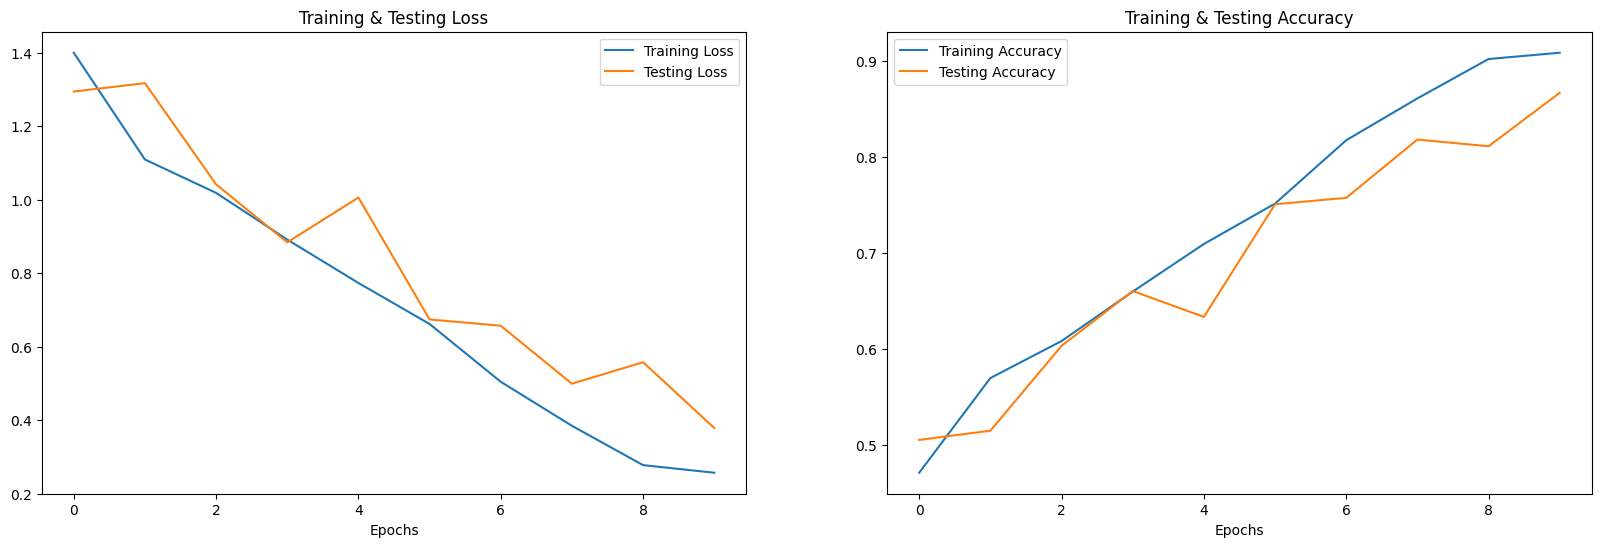

In [53]:
print("Accuracy of our model on test data : " , model.evaluate(x_testcnn,y_test)[1]*100 , "%")

# Get the actual number of epochs from history
epochs = range(len(history.history['accuracy']))  # Adjust to match training length

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(20, 6)

# Extract training and validation metrics from history
train_loss = history.history['loss']
test_loss = history.history['val_loss']
train_acc = history.history['accuracy']
test_acc = history.history['val_accuracy']

# Training & Testing Loss Plot
ax[0].plot(epochs, train_loss, label='Training Loss')
ax[0].plot(epochs, test_loss, label='Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

# Training & Testing Accuracy Plot
ax[1].plot(epochs, train_acc, label='Training Accuracy')
ax[1].plot(epochs, test_acc, label='Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")

plt.show()

In [54]:
# predicting on test data.
pred_test0 = model.predict(x_testcnn)
y_pred0 = encoder.inverse_transform(pred_test0)
y_test0 = encoder.inverse_transform(y_test)

# Check for random predictions
df0 = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df0['Predicted Labels'] = y_pred0.flatten()
df0['Actual Labels'] = y_test0.flatten()

df0.head(10)

305/305 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step


,Predicted Labels,Actual Labels
0,disgust,disgust
1,sad,disgust
2,fear,happy
3,fear,fear
4,fear,fear
5,angry,angry
6,happy,happy
7,angry,angry
8,happy,happy
9,surprise,surprise


In [55]:
df0

,Predicted Labels,Actual Labels
0,disgust,disgust
1,sad,disgust
2,fear,happy
3,fear,fear
4,fear,fear
...,...,...
9725,happy,happy
9726,angry,angry
9727,happy,happy
9728,fear,fear


# Evalutation

Results of best model

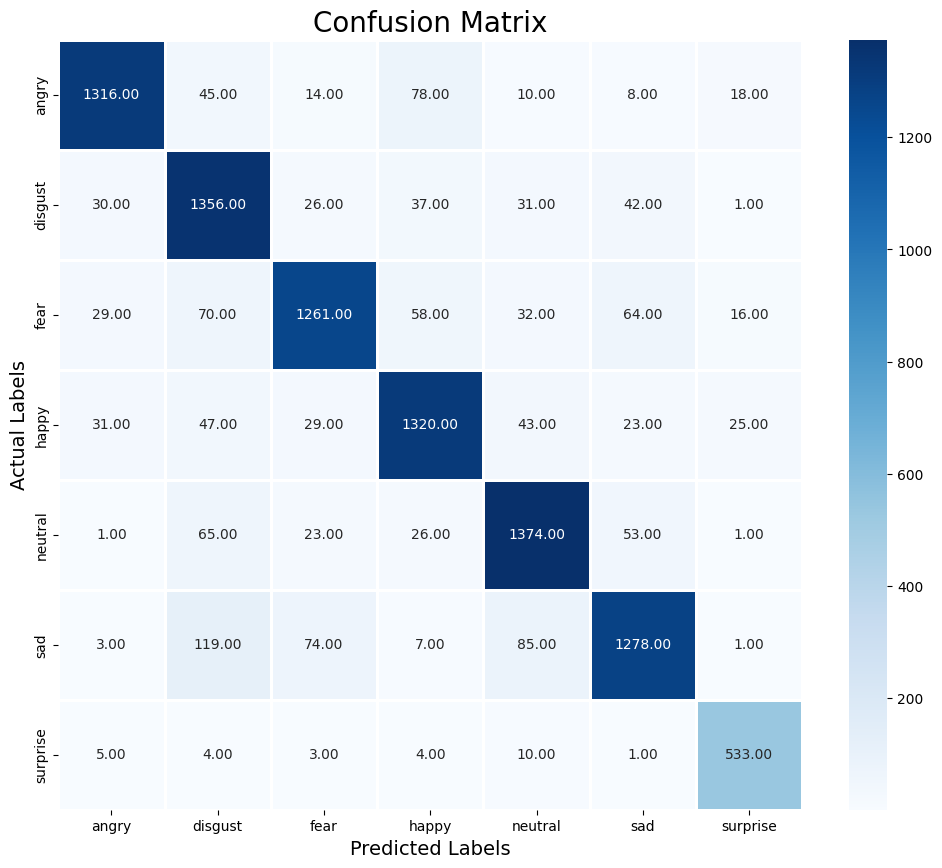

              precision    recall  f1-score   support

       angry       0.93      0.88      0.91      1489
     disgust       0.79      0.89      0.84      1523
        fear       0.88      0.82      0.85      1530
       happy       0.86      0.87      0.87      1518
     neutral       0.87      0.89      0.88      1543
         sad       0.87      0.82      0.84      1567
    surprise       0.90      0.95      0.92       560

    accuracy                           0.87      9730
   macro avg       0.87      0.88      0.87      9730
weighted avg       0.87      0.87      0.87      9730

305/305 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step


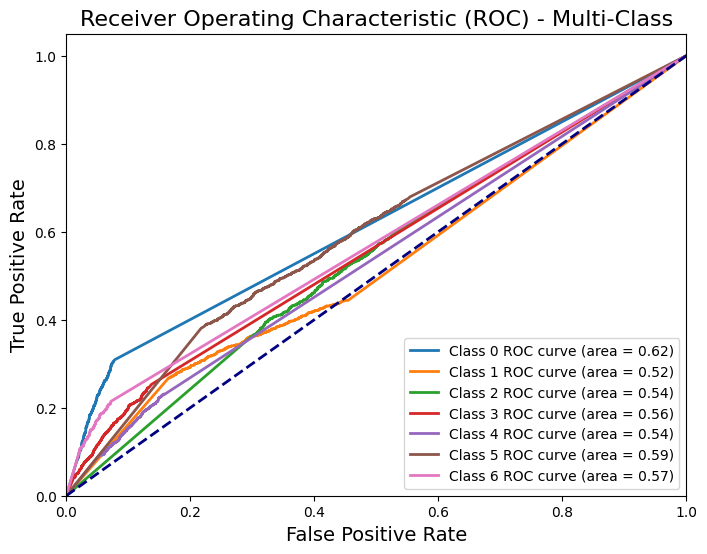

Model Accuracy: 88.00%

Metrics for Class 0:
Type I Error (False Positive Rate): 0.0120
Type II Error (False Negative Rate): 0.1162
Accuracy: 0.9720
Specificity (True Negative Rate): 0.9880
Sensitivity (True Positive Rate): 0.8838

Metrics for Class 1:
Type I Error (False Positive Rate): 0.0426
Type II Error (False Negative Rate): 0.1097
Accuracy: 0.9469
Specificity (True Negative Rate): 0.9574
Sensitivity (True Positive Rate): 0.8903

Metrics for Class 2:
Type I Error (False Positive Rate): 0.0206
Type II Error (False Negative Rate): 0.1758
Accuracy: 0.9550
Specificity (True Negative Rate): 0.9794
Sensitivity (True Positive Rate): 0.8242

Metrics for Class 3:
Type I Error (False Positive Rate): 0.0256
Type II Error (False Negative Rate): 0.1304
Accuracy: 0.9581
Specificity (True Negative Rate): 0.9744
Sensitivity (True Positive Rate): 0.8696

Metrics for Class 4:
Type I Error (False Positive Rate): 0.0258
Type II Error (False Negative Rate): 0.1095
Accuracy: 0.9609
Specificity (True N

In [58]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import label_binarize

# Assuming y_test0 (actual labels) and y_pred0 (predicted labels from your CNN model)
# Replace this with your actual data if needed:
# y_test0 = np.array([actual labels from your dataset])
# y_pred0 = np.array([predicted labels from your CNN model])

# Confusion Matrix
cm = confusion_matrix(y_test0, y_pred0)

# Plot Confusion Matrix
plt.figure(figsize=(12, 10))
cm_df = pd.DataFrame(cm, index=[str(i) for i in np.unique(y_test0)], columns=[str(i) for i in np.unique(y_test0)])
sns.heatmap(cm_df, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='.2f')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

# Print Classification Report
print(classification_report(y_test0, y_pred0))

# ROC Curve (Binary or Multi-Class)
if len(np.unique(y_test0)) == 2:  # Binary classification
    y_prob = model.predict_proba(X_test)[:, 1]  # Probability for class 1
    fpr, tpr, thresholds = roc_curve(y_test0, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', size=14)
    plt.ylabel('True Positive Rate', size=14)
    plt.title('Receiver Operating Characteristic (ROC)', size=16)
    plt.legend(loc='lower right')
    plt.show()
else:  # Multi-class classification
    y_test_bin = label_binarize(y_test0, classes=np.unique(y_test0))
    y_pred_bin = model.predict(X_test)

    plt.figure(figsize=(8, 6))
    for i in range(y_test_bin.shape[1]):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'Class {i} ROC curve (area = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', size=14)
    plt.ylabel('True Positive Rate', size=14)
    plt.title('Receiver Operating Characteristic (ROC) - Multi-Class', size=16)
    plt.legend(loc='lower right')
    plt.show()

# ============================================
# Model Accuracy (Assuming CNN model accuracy is 0.88)
model_accuracy = 0.88
print(f"Model Accuracy: {model_accuracy * 100:.2f}%")

# ============================================
# Handling Multi-Class: Extract Confusion Matrix Components
# For Multi-Class, we need to handle each class separately
# For each class, we'll compute the True Positives, False Positives, etc.

# Initialize dictionaries to store metrics for each class
metrics = {}
y_test0_1d = np.ravel(y_test0)  # Convert y_test0 to 1D
y_pred0_1d = np.ravel(y_pred0)  # Convert y_pred0 to 1D


for i in range(len(np.unique(y_test0_1d))):  # Iterate over each class
    # Use the 1D arrays for confusion matrix calculation
    tn, fp, fn, tp = confusion_matrix(y_test0_1d == np.unique(y_test0_1d)[i], y_pred0_1d == np.unique(y_test0_1d)[i]).ravel()

    # Type I Error (False Positive Rate) for each class
    type_1_error = fp / (fp + tn)

    # Type II Error (False Negative Rate) for each class
    type_2_error = fn / (fn + tp)

    # Accuracy, Specificity, Sensitivity for each class
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)

    metrics[f'Class {i}'] = {
        'Type I Error (False Positive Rate)': type_1_error,
        'Type II Error (False Negative Rate)': type_2_error,
        'Accuracy': accuracy,
        'Specificity (True Negative Rate)': specificity,
        'Sensitivity (True Positive Rate)': sensitivity
    }

# Display metrics for each class
for class_label, metric_values in metrics.items():
    print(f"\nMetrics for {class_label}:")
    for metric, value in metric_values.items():
        print(f"{metric}: {value:.4f}")


In [59]:
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras.models import load_model
import os

# Load the pre-trained model
loaded_model = load_model('/content/best_model1_weights.h5')  # Provide the correct path to your model

# Compile the model (if not already compiled)
loaded_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Function to load and preprocess audio
def preprocess_audio(audio_path, target_sr=22050, frame_length=2048, hop_length=512):
    # Load the audio file using librosa
    # Use duration=2.5 and offset=0.6 to match the original feature extraction
    data, sr = librosa.load(audio_path, sr=target_sr, duration=2.5, offset=0.6)

    # Extract features using the original 'extract_features' function
    # This ensures the same feature set as used during training
    features = extract_features(data, sr=sr, frame_length=frame_length, hop_length=hop_length)

    # Reshape to match the CNN model's input
    # The original model was trained on (samples, features, 1)
    features = features.reshape(1, features.shape[0], 1)

    return features

# Load and preprocess the test audio file
audio_path = '/content/Ravdess/audio_speech_actors_01-24/Actor_01/03-01-01-01-01-01-01.wav'  # Provide the correct path to your audio file
audio_features = preprocess_audio(audio_path)

# Predict the class of the audio
prediction = loaded_model.predict(audio_features)

# Convert the prediction to the corresponding label (for multi-class classification)
predicted_class = np.argmax(prediction, axis=1)

# Define class labels for your emotions
class_labels = ['surprise', 'sad', 'disgust', 'fear', 'happy', 'sad', 'neutral']

# Output the predicted label
print(f"Predicted emotion: {class_labels[predicted_class[0]]}")

# Optionally, evaluate the model on the test set
score = loaded_model.evaluate(x_testcnn, y_test)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted emotion: disgust
305/305 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.8709 - loss: 0.3670
compile_metrics: 86.72%


In [60]:
loaded_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn,y_test)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

305/305 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.8709 - loss: 0.3670
compile_metrics: 86.72%


305/305 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step


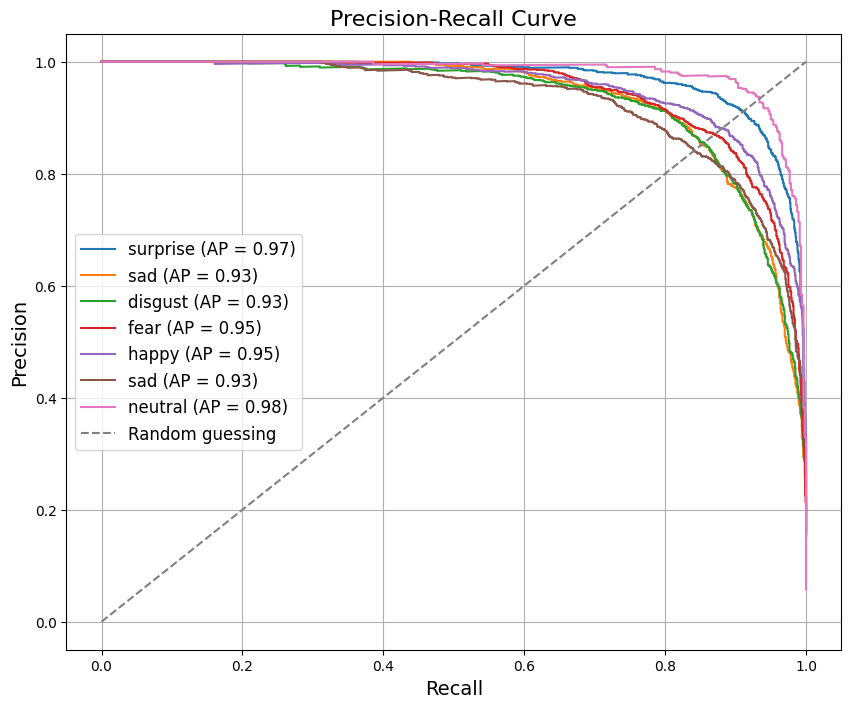

In [61]:
from sklearn.metrics import precision_recall_curve, average_precision_score #import precision_recall_curve and average_precision_score

y_pred_probs = loaded_model.predict(x_testcnn)  # Predictions for the entire test set

# Assuming y_test is one-hot encoded (categorical), you can calculate precision-recall curves for each class
n_classes = len(class_labels)

# Plot PR curve for each class
plt.figure(figsize=(10, 8))

for i in range(n_classes):
    # Get the true labels and predicted probabilities for class i
    y_true = y_test[:, i]  # Actual labels for class i
    y_pred = y_pred_probs[:, i]  # Predicted probabilities for class i

    # Compute precision-recall curve
    precision, recall, _ = precision_recall_curve(y_true, y_pred)

    # Compute average precision score
    avg_precision = average_precision_score(y_true, y_pred)

    # Plot the Precision-Recall curve
    plt.plot(recall, precision, label=f'{class_labels[i]} (AP = {avg_precision:.2f})')

# Plot the line for random guessing
plt.plot([0, 1], [0, 1], linestyle='--', label='Random guessing', color='grey')

# Set plot labels and title
plt.xlabel('Recall', size=14)
plt.ylabel('Precision', size=14)
plt.title('Precision-Recall Curve', size=16)
plt.legend(loc='best', fontsize=12)
plt.grid(True)
plt.show()